In [1]:
import torch, os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import rearrange, repeat
import copy
import numpy as np

from modules.networks.unet_chain import UNetModelChainFlow

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use only the first GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

class CFDataset(data.Dataset):
    """
    Class to read the numpy dataset for the microstructure
    """
    def __init__(self, data_path='./chain_flow_mnist.npz'):
        self.trajectory = np.load(data_path)['arr_0']

    def __len__(self):
        return self.trajectory.shape[0]

    def __getitem__(self, index):
        return torch.FloatTensor(self.trajectory[index])
    
train_dataset = CFDataset()

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=1
                                           )

def pad(tensor):
    return repeat(tensor, 'b -> b 1 1 1')

In [16]:
class ChainFlow():
    def __init__(self, model=None, device=None, n_trajectory=None, nfe=None):
        self.device = device
        self.model = model.to(self.device)
        self.N = n_trajectory
        self.nfe = nfe
        
    def get_train_tuple(self, batch):
        n = torch.randint(low=0, high=self.N-1, size=(batch.shape[0],))
        range_indices = torch.arange(batch.shape[0])
        x0 = batch[range_indices, n, :, :, :]
        x1 = batch[range_indices, n+1, :, :, :]
        t = torch.rand((batch.shape[0],)).to(self.device)
        xt = pad(t) * x1 + (1. - pad(t)) * x0
        target = x1 - x0
        n = (n / self.N).type(t.dtype).to(self.device)
        return xt, t, n, target
    
    def chainflow_loss(self, batch):
        xt, t, n, target = self.get_train_tuple(batch)
        
        pred = self.model(xt, t, n)
        
        loss = F.mse_loss(pred, target)
        
        return loss
        
    @torch.no_grad()
    def sample_chainflow_ode(self, batch):
        dt = 1./self.nfe
        x0 = batch[:,0,:,:,:]
        x = x0.detach().clone().to(self.device)
        
        trajectory = [x]
        sub_trajectory = [x]
        
        for i in range(self.N):
            n = (torch.ones((batch.shape[0],)) * (i / self.N)).to(self.device)
            for j in range(self.nfe):
                t = (torch.ones((batch.shape[0],)) * (j * dt)).to(self.device)
                velocity = self.model(x, t, n)
                x = x + velocity * dt
                sub_trajectory.append(x)
            trajectory.append(x)
                
        return trajectory, sub_trajectory

In [17]:
def train_chainflow(data_loader, chainflow, opt, device):
    chainflow.model.train()
    running_loss = 0.0
    for data in data_loader:
        data = data.to(device)
        
        loss = chainflow.chainflow_loss(data)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [20]:
# Init all of our models
model = UNetModelChainFlow()
CF = ChainFlow(model=model, device=device, n_trajectory=10, nfe=500)

print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

for i in tqdm(range(100)):
    loss_rec = train_chainflow(train_loader, CF, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)
    
# torch.save(model.state_dict(), '/data/edherron/genmod/rectified_flow_weights/rf_1.pt')

Number of parameters:  3806113


  1%|          | 1/100 [00:03<05:10,  3.14s/it]

loss from epoch  0 :  0.13962212788022083


  2%|▏         | 2/100 [00:06<05:08,  3.14s/it]

loss from epoch  1 :  0.13699510045673535


  3%|▎         | 3/100 [00:09<05:04,  3.14s/it]

loss from epoch  2 :  0.12629857238220132


  4%|▍         | 4/100 [00:12<05:01,  3.14s/it]

loss from epoch  3 :  0.11098499920057214


  5%|▌         | 5/100 [00:15<04:58,  3.14s/it]

loss from epoch  4 :  0.1032343859905782


  6%|▌         | 6/100 [00:18<04:55,  3.15s/it]

loss from epoch  5 :  0.07087251754558604


  7%|▋         | 7/100 [00:22<04:53,  3.16s/it]

loss from epoch  6 :  0.048451732844114304


  8%|▊         | 8/100 [00:25<04:51,  3.17s/it]

loss from epoch  7 :  0.04002728151238483


  9%|▉         | 9/100 [00:28<04:48,  3.17s/it]

loss from epoch  8 :  0.036092886134334236


 10%|█         | 10/100 [00:31<04:45,  3.17s/it]

loss from epoch  9 :  0.03177897211002267


 11%|█         | 11/100 [00:34<04:42,  3.18s/it]

loss from epoch  10 :  0.030259753374949745


 12%|█▏        | 12/100 [00:37<04:39,  3.18s/it]

loss from epoch  11 :  0.028119145204191624


 13%|█▎        | 13/100 [00:41<04:36,  3.18s/it]

loss from epoch  12 :  0.02642589758919633


 14%|█▍        | 14/100 [00:44<04:35,  3.20s/it]

loss from epoch  13 :  0.024997941906685413


 15%|█▌        | 15/100 [00:47<04:34,  3.22s/it]

loss from epoch  14 :  0.024980736086549965


 16%|█▌        | 16/100 [00:50<04:29,  3.21s/it]

loss from epoch  15 :  0.023708232314042423


 17%|█▋        | 17/100 [00:54<04:25,  3.20s/it]

loss from epoch  16 :  0.0230154353801323


 18%|█▊        | 18/100 [00:57<04:22,  3.20s/it]

loss from epoch  17 :  0.021800010910500652


 19%|█▉        | 19/100 [01:00<04:20,  3.21s/it]

loss from epoch  18 :  0.02156978440673455


 20%|██        | 20/100 [01:03<04:19,  3.24s/it]

loss from epoch  19 :  0.021366939920446148


 21%|██        | 21/100 [01:07<04:15,  3.24s/it]

loss from epoch  20 :  0.023668954148888588


 22%|██▏       | 22/100 [01:10<04:12,  3.24s/it]

loss from epoch  21 :  0.01963657934380614


 23%|██▎       | 23/100 [01:13<04:11,  3.26s/it]

loss from epoch  22 :  0.019031154639695003


 24%|██▍       | 24/100 [01:16<04:07,  3.26s/it]

loss from epoch  23 :  0.018608919142381004


 25%|██▌       | 25/100 [01:20<04:04,  3.26s/it]

loss from epoch  24 :  0.019058962878973587


 26%|██▌       | 26/100 [01:23<04:00,  3.25s/it]

loss from epoch  25 :  0.0175999296910089


 27%|██▋       | 27/100 [01:26<03:57,  3.26s/it]

loss from epoch  26 :  0.016254994977751503


 28%|██▊       | 28/100 [01:29<03:56,  3.29s/it]

loss from epoch  27 :  0.016165841370821


 29%|██▉       | 29/100 [01:33<03:54,  3.31s/it]

loss from epoch  28 :  0.016243187508181385


 30%|███       | 30/100 [01:36<03:50,  3.29s/it]

loss from epoch  29 :  0.016286166303831597


 31%|███       | 31/100 [01:39<03:45,  3.27s/it]

loss from epoch  30 :  0.01607454317095487


 32%|███▏      | 32/100 [01:43<03:42,  3.28s/it]

loss from epoch  31 :  0.015455599712288898


 33%|███▎      | 33/100 [01:46<03:40,  3.30s/it]

loss from epoch  32 :  0.015117307315054148


 34%|███▍      | 34/100 [01:49<03:36,  3.28s/it]

loss from epoch  33 :  0.014969815540572872


 35%|███▌      | 35/100 [01:52<03:32,  3.27s/it]

loss from epoch  34 :  0.014712455479995064


 36%|███▌      | 36/100 [01:56<03:29,  3.27s/it]

loss from epoch  35 :  0.014626354262556719


 37%|███▋      | 37/100 [01:59<03:26,  3.27s/it]

loss from epoch  36 :  0.014930224815464539


 38%|███▊      | 38/100 [02:02<03:22,  3.27s/it]

loss from epoch  37 :  0.014359329867622127


 39%|███▉      | 39/100 [02:05<03:19,  3.27s/it]

loss from epoch  38 :  0.013442032120150068


 40%|████      | 40/100 [02:09<03:16,  3.27s/it]

loss from epoch  39 :  0.013320312065922695


 41%|████      | 41/100 [02:12<03:13,  3.27s/it]

loss from epoch  40 :  0.014139367550935434


 42%|████▏     | 42/100 [02:15<03:09,  3.27s/it]

loss from epoch  41 :  0.013846350914758184


 43%|████▎     | 43/100 [02:19<03:05,  3.25s/it]

loss from epoch  42 :  0.012801571627673895


 44%|████▍     | 44/100 [02:22<03:01,  3.24s/it]

loss from epoch  43 :  0.013092091954920603


 45%|████▌     | 45/100 [02:25<02:58,  3.24s/it]

loss from epoch  44 :  0.013632454342492249


 46%|████▌     | 46/100 [02:28<02:55,  3.25s/it]

loss from epoch  45 :  0.014709588180741539


 47%|████▋     | 47/100 [02:32<02:53,  3.27s/it]

loss from epoch  46 :  0.012540131240435268


 48%|████▊     | 48/100 [02:35<02:50,  3.27s/it]

loss from epoch  47 :  0.012092343086133833


 49%|████▉     | 49/100 [02:38<02:46,  3.27s/it]

loss from epoch  48 :  0.012272894301492235


 50%|█████     | 50/100 [02:41<02:43,  3.27s/it]

loss from epoch  49 :  0.012088052806970865


 51%|█████     | 51/100 [02:45<02:40,  3.27s/it]

loss from epoch  50 :  0.011903947016791157


 52%|█████▏    | 52/100 [02:48<02:37,  3.27s/it]

loss from epoch  51 :  0.011701216880718002


 53%|█████▎    | 53/100 [02:51<02:33,  3.27s/it]

loss from epoch  52 :  0.011732535436749458


 54%|█████▍    | 54/100 [02:54<02:30,  3.27s/it]

loss from epoch  53 :  0.011348412372171879


 55%|█████▌    | 55/100 [02:58<02:26,  3.27s/it]

loss from epoch  54 :  0.010995560811589594


 56%|█████▌    | 56/100 [03:01<02:23,  3.27s/it]

loss from epoch  55 :  0.011208296186574127


 57%|█████▋    | 57/100 [03:04<02:20,  3.26s/it]

loss from epoch  56 :  0.01135281157558379


 58%|█████▊    | 58/100 [03:07<02:16,  3.25s/it]

loss from epoch  57 :  0.01693146655578976


 59%|█████▉    | 59/100 [03:11<02:12,  3.24s/it]

loss from epoch  58 :  0.012977788022354893


 60%|██████    | 60/100 [03:14<02:09,  3.25s/it]

loss from epoch  59 :  0.010950179284681444


 61%|██████    | 61/100 [03:17<02:06,  3.25s/it]

loss from epoch  60 :  0.010767461651045343


 62%|██████▏   | 62/100 [03:20<02:03,  3.25s/it]

loss from epoch  61 :  0.01094959623625745


 63%|██████▎   | 63/100 [03:24<01:59,  3.24s/it]

loss from epoch  62 :  0.01137000702969406


 64%|██████▍   | 64/100 [03:27<01:56,  3.22s/it]

loss from epoch  63 :  0.010900785012737564


 65%|██████▌   | 65/100 [03:30<01:53,  3.24s/it]

loss from epoch  64 :  0.010402115588278874


 66%|██████▌   | 66/100 [03:33<01:50,  3.24s/it]

loss from epoch  65 :  0.010236933462969635


 67%|██████▋   | 67/100 [03:37<01:47,  3.24s/it]

loss from epoch  66 :  0.010695540670143522


 68%|██████▊   | 68/100 [03:40<01:42,  3.22s/it]

loss from epoch  67 :  0.010271401954409868


 69%|██████▉   | 69/100 [03:43<01:39,  3.21s/it]

loss from epoch  68 :  0.010671182333127312


 70%|███████   | 70/100 [03:46<01:36,  3.21s/it]

loss from epoch  69 :  0.010215735791817955


 71%|███████   | 71/100 [03:49<01:33,  3.21s/it]

loss from epoch  70 :  0.010339830070734024


 72%|███████▏  | 72/100 [03:53<01:29,  3.21s/it]

loss from epoch  71 :  0.00994705801586742


 73%|███████▎  | 73/100 [03:56<01:26,  3.21s/it]

loss from epoch  72 :  0.009829731698593368


 74%|███████▍  | 74/100 [03:59<01:23,  3.21s/it]

loss from epoch  73 :  0.009976010810097923


 75%|███████▌  | 75/100 [04:02<01:20,  3.23s/it]

loss from epoch  74 :  0.01010790418671525


 76%|███████▌  | 76/100 [04:05<01:17,  3.23s/it]

loss from epoch  75 :  0.009540010324638823


 77%|███████▋  | 77/100 [04:09<01:14,  3.23s/it]

loss from epoch  76 :  0.009563075823952322


 78%|███████▊  | 78/100 [04:12<01:11,  3.23s/it]

loss from epoch  77 :  0.009382640618992888


 79%|███████▉  | 79/100 [04:15<01:07,  3.23s/it]

loss from epoch  78 :  0.009238228971219582


 80%|████████  | 80/100 [04:18<01:04,  3.22s/it]

loss from epoch  79 :  0.009923411452251932


 81%|████████  | 81/100 [04:22<01:01,  3.22s/it]

loss from epoch  80 :  0.009690867453489614


 82%|████████▏ | 82/100 [04:25<00:57,  3.21s/it]

loss from epoch  81 :  0.009789126560739849


 83%|████████▎ | 83/100 [04:28<00:54,  3.21s/it]

loss from epoch  82 :  0.00961915041198549


 84%|████████▍ | 84/100 [04:31<00:51,  3.22s/it]

loss from epoch  83 :  0.009552198664649673


 85%|████████▌ | 85/100 [04:34<00:48,  3.21s/it]

loss from epoch  84 :  0.009966140774929005


 86%|████████▌ | 86/100 [04:38<00:44,  3.20s/it]

loss from epoch  85 :  0.010773449447815832


 87%|████████▋ | 87/100 [04:41<00:41,  3.20s/it]

loss from epoch  86 :  0.009530540252023417


 88%|████████▊ | 88/100 [04:44<00:38,  3.19s/it]

loss from epoch  87 :  0.009536570019048193


 89%|████████▉ | 89/100 [04:47<00:35,  3.19s/it]

loss from epoch  88 :  0.009297595764307873


 90%|█████████ | 90/100 [04:50<00:31,  3.19s/it]

loss from epoch  89 :  0.010193282576358837


 91%|█████████ | 91/100 [04:54<00:28,  3.19s/it]

loss from epoch  90 :  0.009920953772962093


 92%|█████████▏| 92/100 [04:57<00:25,  3.19s/it]

loss from epoch  91 :  0.009366072268913622


 93%|█████████▎| 93/100 [05:00<00:22,  3.20s/it]

loss from epoch  92 :  0.009431426129911257


 94%|█████████▍| 94/100 [05:03<00:19,  3.20s/it]

loss from epoch  93 :  0.009505850667862789


 95%|█████████▌| 95/100 [05:06<00:16,  3.20s/it]

loss from epoch  94 :  0.009642237959348637


 96%|█████████▌| 96/100 [05:10<00:12,  3.19s/it]

loss from epoch  95 :  0.009051208809504042


 97%|█████████▋| 97/100 [05:13<00:09,  3.20s/it]

loss from epoch  96 :  0.009634169911884743


 98%|█████████▊| 98/100 [05:16<00:06,  3.18s/it]

loss from epoch  97 :  0.009422211988788584


 99%|█████████▉| 99/100 [05:19<00:03,  3.18s/it]

loss from epoch  98 :  0.008634568131326334


100%|██████████| 100/100 [05:22<00:00,  3.23s/it]

loss from epoch  99 :  0.009856157976648083


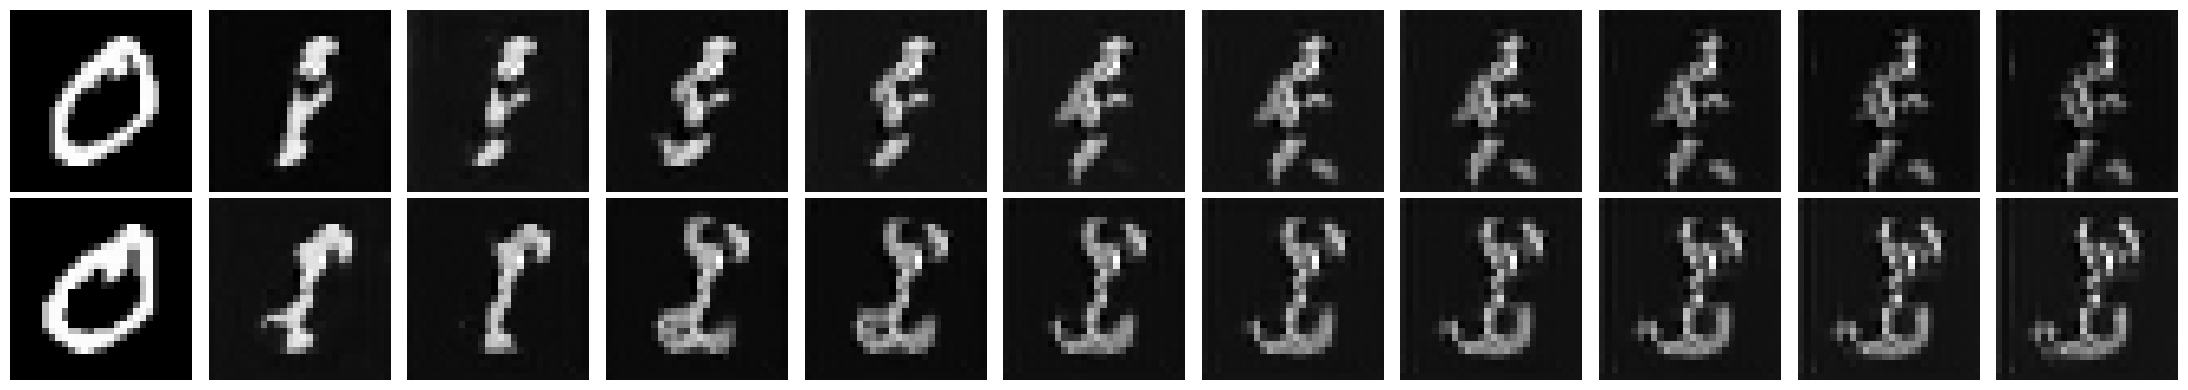

In [21]:
x = train_dataset[:2]
trajectory, sub_trajectory = CF.sample_chainflow_ode(x)

fig, axes = plt.subplots(nrows=2, ncols=11, figsize=(22, 4))

for i in range(11):
    for j in range(2):
        ax = axes[j, i]
        ax.imshow(trajectory[i][j, 0].detach().cpu().numpy(), cmap='gray')
        ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
x = train_dataset[:2]
trajectory, sub_trajectory = CF.sample_chainflow_ode(x)

# Assuming `data_list` is your list of tensors
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for i, ax in enumerate(axs.flat):
    img = trajectory[i].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
    ax.imshow(img, cmap='gray')  # Plot as grayscale image
    ax.set_title(f'Index {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
z = torch.randn((10, 1, 28, 28))
trajectories = [RF.sample_ode(z0=z[i].unsqueeze(0)) for i in range(10)]

# Set up the plot for 10 rows of trajectories, each with 11 time steps (same as the column convention)
fig, axs = plt.subplots(10, 11, figsize=(20, 20))  # Adjust figsize as needed, ensure there's enough space

for row, trajectory in enumerate(trajectories):
    for col, ax in enumerate(axs[row]):
        idx = col * 100  # Every 100th element as in the original convention
        if idx < len(trajectory):
            img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
            ax.imshow(img, cmap='gray')  # Plot as grayscale image
            ax.set_title(f'Index {idx}')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

In [ ]:
z = torch.randn((1, 1, 28, 28))
trajectory = RF.sample_ode(z0 = z, N = 10)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory is your list of tensors with exactly 11 elements
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for idx, ax in enumerate(axs.flat):
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Step {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

# Rectified Flow 2 model.
Here we take the pretrained RF model above and fine tune it on DETERMINISTIC pairs of z_0 and z_1. By randomly sampling z_0 and generating a new sample z_1 with the sampled z_0. 

In [ ]:
z10 = []
z11 = []

for _ in range(100):  # The loop runs 10 times
    z = torch.randn((512, 1, 28, 28))  # Generate a new z of the specified size
    trajectory = RF.sample_ode(z0 = z, N = 10)  # Compute the trajectory

    # Assuming the trajectory output is a list of 11 tensors for each z in the batch
    z10.extend(trajectory[0])  # Extend z10 with the first tensors of each trajectory
    z11.extend(trajectory[-1])  # Extend z11 with the last tensors of each trajectory

# Check the lengths, should each be 10*512
print("Length of z10:", len(z10))
print("Length of z11:", len(z11))

z10_tensor = torch.stack(z10)  # Stack all tensors in z10 to create one tensor
z11_tensor = torch.stack(z11)  # Stack all tensors in z11 to create one tensor

print("z10 tensor shape:", z10_tensor.shape)
print("z11 tensor shape:", z11_tensor.shape)

z1_pairs = torch.stack([z10_tensor, z11_tensor], dim=1)
print("z1_pairs shape: ", z1_pairs.shape)

In [ ]:
def train_rectified_flow_2(inner_iters, rectified_flow, opt, device):
    rectified_flow.model.train()
    running_loss = 0.0
    for _ in tqdm(range(inner_iters)):
        indices = torch.randperm(len(z10))[:256]
        batch = z1_pairs[indices]
        z0 = batch[:, 0].detach().clone()
        z1 = batch[:, 1].detach().clone()
        z0 = z0.to(device)
        z1 = z1.to(device)
        
        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)
        
        pred = rectified_flow.model(z_t, t)
        
        loss = F.mse_loss(pred, target)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(z10)
    return avg_loss

In [ ]:
# Init all of our models
model_rf2 = UNetModel()
model_rf2.load_state_dict(torch.load('/data/edherron/genmod/rectified_flow_weights/rf_1.pt'))
RF_2 = RectifiedFlow(model=model_rf2, device=device, num_steps=100)
optimizer = torch.optim.Adam(RF_2.model.parameters(), lr=1e-4)

loss_rec = train_rectified_flow_2(50, RF_2, optimizer, device)
print('loss from epoch ', i, ': ', loss_rec)

# torch.save(model_rf2.state_dict(), '/data/edherron/genmod/rectified_flow_weights/rf_2.pt')

In [ ]:
z = torch.randn((1, 1, 28, 28))
trajectory = RF_2.sample_ode(z0 = z, N = 10)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory is your list of tensors with exactly 11 elements
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for idx, ax in enumerate(axs.flat):
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Step {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

In [ ]:
z = torch.randn((1, 1, 28, 28))
trajectory = RF_2.sample_ode(z0 = z, N = 1)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory is your list of tensors with exactly 11 elements
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for idx, ax in enumerate(axs.flat):
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Step {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

In [ ]:
# plot out velocities as well as trajectory
z = torch.randn((1, 1, 28, 28))
trajectory, velocities = RF_2.sample_ode(z0 = z, N = 10, return_velocities=True)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory and velocities are your lists of tensors
fig, axs = plt.subplots(2, len(trajectory), figsize=(20, 4))  # Adjust figsize as needed

for idx in range(len(trajectory)):
    # Plot trajectory tensors in the top row
    img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
    axs[0, idx].imshow(img, cmap='gray')  # Plot as grayscale image
    axs[0, idx].set_title(f'Trajectory Step {idx}')
    axs[0, idx].axis('off')
    
    # Plot velocity tensors in the bottom row
    if idx < len(velocities):
        vel_img = velocities[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        axs[1, idx].imshow(vel_img, cmap='gray')  # Plot as grayscale image
        axs[1, idx].set_title(f'Velocity Step {idx}')
        axs[1, idx].axis('off')
    else:
        axs[1, idx].axis('off')  # Hide axes for plots without corresponding velocity tensor

plt.tight_layout()
plt.show()
